In [985]:
import sys
import json
from os import listdir
from itertools import product
import importlib
import matplotlib.pyplot as plt
import numpy as np

import input_output
importlib.reload(input_output)
import inheritance_states
importlib.reload(inheritance_states)
import transition_matrices
importlib.reload(transition_matrices)
import genotypes
importlib.reload(genotypes)
import losses
importlib.reload(losses)
import viterbi
importlib.reload(viterbi)

<module 'viterbi' from '/Users/kelley/Projects/PhasingFamilies/phase/viterbi.py'>

In [1090]:
# Read in command line arguments
chrom = '22'

data_dir = '../../DATA/ihart/genotypes'
param_file = '../params/ihart_multiloss_params.json'
num_loss_regions = 2
assembly = '37'
ped_file = '../../DATA/ihart/ihart.ped'
###detect_deletions = False
###ped_file = '../../DATA/ihart/ihart.ped'

#data_dir = '../../DATA/spark/genotypes'
#ped_file = '../../DATA/spark/spark.ped.quads.ped'
#param_file = '../params/spark_quads_multiloss_params.json'
#num_loss_regions = 1
#assembly = '38'

#data_dir = '../../DATA/ancestry/genotypes'
#ped_file = '../../DATA/ancestry/ancestry.ped'
#param_file = '../params/ancestry_multiloss_params.json'
#num_loss_regions = 1
#assembly = '37'

detect_deletions = False
detect_consanguinity = True

# set up filenames
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

with open(param_file, 'r') as f: 
    params = json.load(f)

In [1091]:
#params['-log10(P[maternal_crossover])'] = 20
#params['-log10(P[paternal_crossover])'] = 20

In [1092]:
# pull families of interest
families = input_output.pull_families(ped_file)

families pulled 1002


In [1093]:
# make sure at least one individual has genetic data (chromosome 1 chosen arbitrarily)
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = set([line.strip() for line in f])
families = [x for x in families if len(set(x.individuals) & sample_ids)>0]

In [1094]:
num_unrelated_individuals = sum([f.num_ancestors() for f in families])
print('unrelated individuals in dataset', num_unrelated_individuals)


unrelated individuals in dataset 2110


In [1095]:
af_boundaries = np.arange(-np.log10(0.25), np.log10(2*num_unrelated_individuals/3), np.log10(2)).tolist() # use rule of 3; we can't differentiate allele frequencies any smaller than 3/(2*num unrelated individuals).
af_boundaries.extend([-np.log10(1-(10.0**-x)) for x in af_boundaries[1:]])
af_boundaries = np.array(sorted(af_boundaries, reverse=True))
print(af_boundaries)


[3.01029996e+00 2.70926996e+00 2.40823997e+00 2.10720997e+00
 1.80617997e+00 1.50514998e+00 1.20411998e+00 9.03089987e-01
 6.02059991e-01 5.79919470e-02 2.80287236e-02 1.37882845e-02
 6.83942453e-03 3.40624869e-03 1.69978488e-03 8.49060841e-04
 4.24322928e-04]


In [1096]:
# if we're detecting consanguinity, restrict to nuclear families
if detect_consanguinity:
    families = [x for x in families if x.num_ancestors()==2 and len(x.ordered_couples)==1]
    
    # to detect consanguinity, model a shared ancestor
    for family in families:
        family.add_child(family.mat_ancestors[0], 'mat_shared_ancestor', 'pat_shared_ancestor')
        family.add_child(family.pat_ancestors[0], 'mat_shared_ancestor', 'pat_shared_ancestor')
    
print(len(families))

912


In [1097]:
import random


#family = random.choice(families)
#family = [f for f in families if f.id=='SF0006106.SP0006106.SP0006171'][0]
family = [f for f in families if f.id=='AU3199'][0]
print('family', family.id, family.individuals)
print(family.parents_to_children.items())

family AU3199 ['mat_shared_ancestor', 'pat_shared_ancestor', 'AU3199201', 'AU3199202', 'AU3199301', 'AU3199303', 'AU3199302']
dict_items([(('AU3199202', 'AU3199201'), ['AU3199301', 'AU3199303', 'AU3199302']), (('mat_shared_ancestor', 'pat_shared_ancestor'), ['AU3199201', 'AU3199202'])])


In [1098]:
importlib.reload(inheritance_states)
importlib.reload(transition_matrices)

# create inheritance states
if chrom == 'X':
    states = inheritance_states.InheritanceStates(family, detect_deletions, True, num_loss_regions)
else:
    states = inheritance_states.InheritanceStates(family, detect_deletions, detect_deletions, num_loss_regions)

# create transition matrix
transitions = transition_matrices.TransitionMatrix(states, params)
                

fixed [('AU3199201', 'mat'), ('AU3199201', 'pat'), ('AU3199301', 'mat'), ('AU3199301', 'pat')]
inheritance states (128, 15)
transitions (128, 10)


In [1099]:
importlib.reload(losses)

# create loss function
loss = losses.LazyLoss(states, family, params, num_loss_regions, af_boundaries)


no data ['mat_shared_ancestor', 'pat_shared_ancestor']
mat_shared_ancestor
	0/0	0/1	1/1	./.
0/0	0.0000-0.0000	inf-inf	inf-inf	inf-inf
0/1	0.0000-0.0000	inf-inf	inf-inf	inf-inf
1/1	0.0000-0.0000	inf-inf	inf-inf	inf-inf
-/0	0.0000-0.0000	inf-inf	inf-inf	inf-inf
-/1	0.0000-0.0000	inf-inf	inf-inf	inf-inf
-/-	0.0000-0.0000	inf-inf	inf-inf	inf-inf
pat_shared_ancestor
	0/0	0/1	1/1	./.
0/0	0.0000-0.0000	inf-inf	inf-inf	inf-inf
0/1	0.0000-0.0000	inf-inf	inf-inf	inf-inf
1/1	0.0000-0.0000	inf-inf	inf-inf	inf-inf
-/0	0.0000-0.0000	inf-inf	inf-inf	inf-inf
-/1	0.0000-0.0000	inf-inf	inf-inf	inf-inf
-/-	0.0000-0.0000	inf-inf	inf-inf	inf-inf
AU3199201
	0/0	0/1	1/1	./.
0/0	0.0002-0.0018	3.8935-2.8384	6.3639-4.6802	3.6229-2.5731
0/1	2.4576-1.6787	0.0020-0.0155	3.0860-2.1661	3.4899-2.1317
1/1	5.7983-3.9423	3.5920-2.1406	0.0002-0.0042	3.5134-2.6602
-/0	0.0002-0.0018	3.8935-2.8384	6.3639-4.6802	3.6229-2.5731
-/1	5.7983-3.9423	3.5920-2.1406	0.0002-0.0042	3.5134-2.6602
-/-	3.5920-2.1406	6.0811-4.3113	3.8935-2

In [1100]:
#af_index = random.choice(np.arange(1, len(af_boundaries)))
#total_prob = np.zeros((states.num_states,))
#for gen in np.array(list(product(*([[0, 1, 2, -1]]*len(family)) + [[af_index]]))):
#    if np.all(gen[:-1]==0) or np.any(gen[:-1]>0):
#        total_prob += np.power(10, -loss(gen))
#        
#assert np.all(np.isclose(total_prob, 1))

In [1101]:
import input_output
importlib.reload(input_output)

# pull genotype data for this family
family_genotypes, family_snp_positions, mult_factor = input_output.pull_gen_data_for_individuals(data_dir, af_boundaries, assembly, chrom, family.individuals)
print('Data pulled')



(5, 934092) (934092,)
genotypes pulled (8, 576653) [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 2 0 ... 0 2 0]]
Data pulled


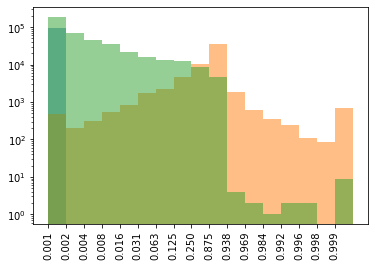

In [1102]:
plt.hist(family_genotypes[-1, mult_factor==0], alpha=0.5, bins=np.arange(len(af_boundaries)+1), log=True)
plt.hist(family_genotypes[-1, (mult_factor>0) & ~np.all(family_genotypes[:-1, :]==0, axis=0)], alpha=0.5, bins=np.arange(len(af_boundaries)+1), log=True)
plt.hist(family_genotypes[-1, (mult_factor>0) & np.all(family_genotypes[:-1, :]==0, axis=0)], alpha=0.5, bins=np.arange(len(af_boundaries)+1), log=True)
plt.xticks(np.arange(len(af_boundaries)), ['%0.3f' % 10.0**-x for x in af_boundaries], rotation=90)
plt.show()

In [1103]:
loss.set_cache(family_genotypes)


cached losses (128, 380) already_calculated 0


In [ ]:
importlib.reload(viterbi)

# forward sweep
v_cost = viterbi.viterbi_forward_sweep(family_genotypes, family_snp_positions, mult_factor, states, transitions, loss)




In [ ]:
importlib.reload(viterbi)

# backward sweep
final_states = viterbi.viterbi_backward_sweep(v_cost, states, transitions)


In [ ]:
final_states_greyed = final_states.copy()
final_states_greyed[:, final_states[-1, :]!=0] = -1

plt.figure(figsize=(15, 7))
plt.imshow(final_states, aspect='auto', vmin=-1)
plt.yticks(np.arange(final_states.shape[0]), 
           ['m%d_del' % i for i in range(1, 2*len(family.mat_ancestors)+1)] + ['p%d_del' % i for i in range(1, 2*len(family.pat_ancestors)+1)] + \
           sum([['%s_mat' % x,'%s_pat' % x] for x in family.individuals], []) + ['loss_region'])

#plt.subplot(2, 1, 2, sharex=ax)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=0) & (family_snp_positions[:, 1]<=20500000), alpha=0.5)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=9600000) & (family_snp_positions[:, 1]<=16300000))
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 1]<=9600000) | (family_snp_positions[:, 0]>=48200000))

#plt.xticks(xticks, xlabels, rotation=90)

#plt.subplot(3, 1, 3)
#plt.plot(np.log2(family_snp_positions[:, 1]-family_snp_positions[:, 0]), marker='.', linestyle='')
#plt.plot(c[1:]-c[:-1], marker='.', linestyle='')
#plt.plot(num_non_mend, marker='.', linestyle='')
#plt.plot(np.convolve(num_non_mend, np.ones((100,)), mode='same'))
#plt.plot(np.convolve(num_missing, np.ones((100,)), mode='same'))
#plt.scatter(family_snp_positions[:, 0], final_states[-1, :], marker='.')
#plt.xticks(family_snp_positions[xticks, 0], xlabels, rotation=90)
#for i in np.where(family_snp_positions[:, 1]-family_snp_positions[:, 0] > 10000)[0]:
#    plt.plot([family_snp_positions[i, 0], family_snp_positions[i, 1]], [final_states[-1, i], final_states[-1, i]], color='grey')
#    #print(family_snp_positions[i, :])
plt.tight_layout()
plt.show()

In [1088]:
np.sum((final_states[-1, :]!=0)*mult_factor)/np.sum(mult_factor)


0.7820610817778121

In [56]:
print(np.sum((final_states[10, :]==0)*mult_factor)/np.sum(mult_factor))
print(np.sum((final_states[11, :]==2)*mult_factor)/np.sum(mult_factor))


0.08166433284944095
0.3331245744530517


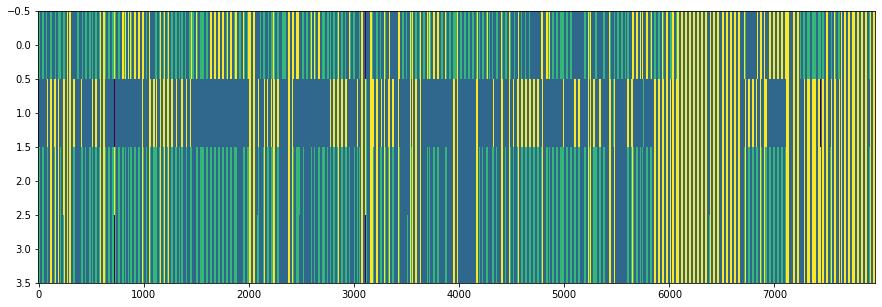

In [598]:
plt.figure(figsize=(15, 5))
indices = final_states[3, :]==0
plt.imshow(family_genotypes[2:-1, indices], aspect='auto', vmin=-1, vmax=2)
plt.show()